In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry

# Define environment

In [2]:
from mouselab import MouselabEnv
from distributions import Categorical, Normal

def make_env(mu=0, sigma=5, quantization=4, cost=1.00, seed=None, branching=[3,1,2], **kwargs):
    if seed is not None:
        np.random.seed(seed)

    def reward(depth):
        if depth > 0:
            x = np.array([-2,-1,1,2])
            return Categorical(mu + sigma * x)
        return 0.

    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

env = make_env(ground_truth=False)

# Optimal policy

Because we can compute the true optimal Q function, we can implement the optimal policy
as a `SoftmaxPolicy` using `Q` as a preference function, and a very low temperature.

In [3]:
from exact import solve
from toolz import compose
h = compose(hash, str)

def maybe(f):
    try:
        return f()
    except IndexError:
        return 0

def hash_x12(state):
    if state == '__term_state__':
        return hash(state)
    s = [hash(x) + 100000 for x in state]
    return (
      h(s[1] + s[2] +
        h(s[3]) +
        h(s[4])
      ) + maybe(lambda:
      h(s[5] + s[6] +
        h(s[7]) +
        h(s[8])
      ) + maybe(lambda:
      h(s[9] + s[10] +
        h(s[11]) +
        h(s[12])
      ) + maybe(lambda:
      h(s[13] + s[14] +
        h(s[15]) +
        h(s[16])
      ))))
    )

from policies import SoftmaxPolicy

def get_optimal_policy(env):
    Q, V, pi, info = solve(env, hash_state=hash_x12)
    print(V(env.init))  # ~ 5 minutes for 312
    return SoftmaxPolicy(Q)
    
optimal_policy = get_optimal_policy(env)
Q = optimal_policy.preference

8.879117548465729


## Simulate rollouts

Running rollouts of the optimal policy on 200 randomly selected environments.

In [4]:
from agents import run_episode
def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env_id, env in envs.items():
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r}

envs = Series([make_env() for _ in range(200)])
df_optimal = DataFrame(simulate(optimal_policy, tdf.envs))

## View rollouts

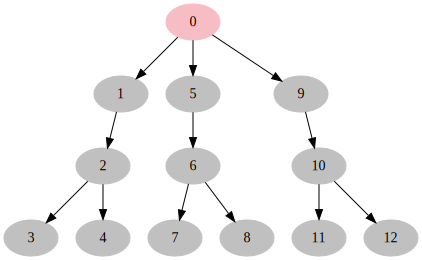

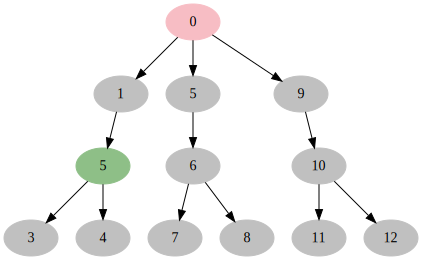

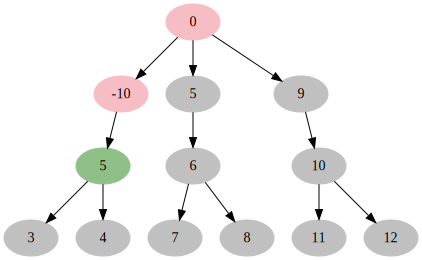

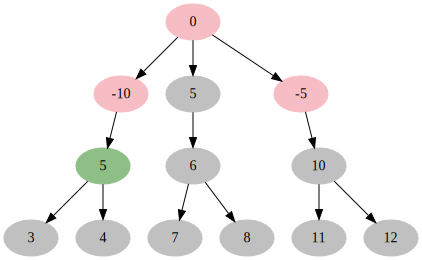

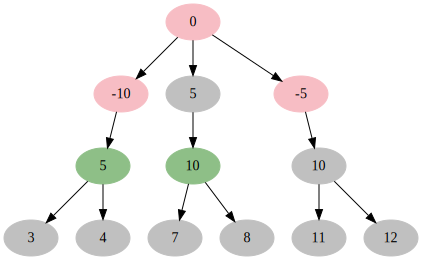

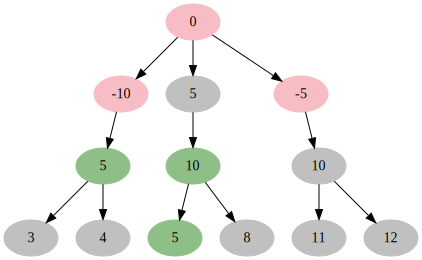

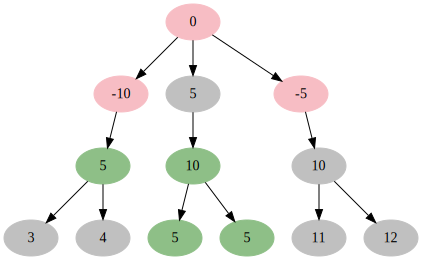

In [5]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)

# Alternative models

## Satisficing and pruning

In [718]:
from functools import wraps

def observed(state, node):
    return not hasattr(state[node], 'sample')

@curry
def satisfruning(preference, prune=None, satisfice=None, env=env):
    @wraps(preference)
    def new_pref(state, action, prune=prune, satisfice=satisfice):
        if action == env.term_action:
            if satisfice is not None:
                satisfied = env.expected_term_reward(state) >= satisfice
                return 1e10 if satisfied else -1e10
        elif prune is not None:
            if env.node_quality(action, state).expectation() <= prune:
                return -1e20
        return preference(state, action)
    
    return new_pref

In [719]:
env.reset()
s = list(env._state)
s[1] = -5
s[5] = 5
s[9] = 5
s = tuple(s)
env._state = s
env.render()

pol = SoftmaxPolicy(satisfruning(Q, satisfice=5))
run_episode(pol, env)
print(pol.preference(s, 2))
print(pol.preference(s, 13))
print(pol.preference(s, 13, satisfice=10))

10.885761260986328
10000000000.0
-10000000000.0


## Preferences

In [720]:
def depth_first(state, action):
    # Don't click nodes not on the frontier.
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    # Prefer nodes that are further from the start
    return len(previous_nodes)

In [721]:
def breadth_first(state, action):
    # Don't click nodes not on the frontier.
    previous_nodes = env.path_to(action)[:-1]
    if not all(observed(state, node) for node in previous_nodes):
        return -1e10
    # Prefer nodes that are closer to the start
    return -len(previous_nodes)

In [722]:
def best_first(state, action):
    q = env.node_quality(action, state)  # note backwards arguments!  plz don't ask why...
    return q.expectation()  # node_quality is a distribution, we just want the mean

In [723]:
def rando(state, action):
    return 0

# Model human data

## Load and preprocess

In [ ]:
from analysis_utils import *
VERSION = 'c1.0'
data = get_data(VERSION, '../experiment/data')
pdf = data['participants']

pdf = pdf.loc[pdf.completed].copy()
print(f'{len(pdf)} participants')

def extract(q):
    return list(map(int, q['click']['state']['target']))

complete = list(pdf.index)
mdf = data['mouselab-mdp'].query('pid == @complete').copy()
mdf['clicks'] = mdf.queries.apply(extract)
mdf['n_clicks'] = mdf.clicks.apply(len)
mdf['thinking'] = mdf['rt'].apply(get(0, default=0))

tdf = mdf.query('block == "test"').copy()
tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

pdf['total_time'] = data['survey-text'].time_elapsed / 60000

pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.mean()
pdf['thinking'] = mdf.groupby('pid').thinking.mean()

In [715]:
def get_env(state_rewards):
    state_rewards[0] = 0
    return make_env(ground_truth=state_rewards)
tdf['env'] = tdf.state_rewards.apply(get_env)

# assert len(tdf.pid.unique()) == tdf.pid.max() + 1
def expand(df):
    for i, row in df.iterrows():
        env = row.env
        env.reset()
        for a in [*row.clicks, env.term_action]:
            yield {'pid': row.pid, 'trial_index': row.trial_index, 'trial_id': row.trial_id,
                   'state': env._state, 'action': a}
            env.step(a)

data = pd.DataFrame(expand(tdf))
print(f'{len(data)} observations)')
data.head()

53 participants


## Likelihood model

In [742]:
class MouselabModel():
    """Computes likelihoods for a softmax policy on a grid of temp and p_error."""
    def __init__(self, env, preference, data):
        self.env = env
        self.policy = SoftmaxPolicy(preference)
        self.data = data
        run_episode(self.policy, self.env)
        self.prefs = np.stack(self.data.state.apply(self.policy.preferences))
        self.prefs -= self.prefs.max(1).reshape(-1, 1)  # prevent float overflow 

        idx = np.arange(len(data))
        self.chosen = (idx, data.action.as_matrix())

    def likelihood(self, temp=1e-9, p_error=None):
        """Returns likelihood for all combinations of temp and p_error given.
        
        Return value has shape (len(self.data), len(temp), len(p_error)).
        """
        temp = np.atleast_1d(temp)
        ep = np.exp(np.einsum('ij,k -> ijk', self.prefs, 1/temp))
        probs = ep[self.chosen] / ep.sum(1)  # shape: (state, temp)
        if p_error is not None:
            p_error = np.atleast_1d(p_error)
            probs = (probs[..., np.newaxis] * (1-p_error) + 
                     self.random_likelihood[..., np.newaxis] * p_error)
        return probs

    @property
    @memoize
    def random_likelihood(self):
        return MouselabModel(self.env, lambda *_: 0, self.data).likelihood()

## Parameters to search over

In [740]:
TEMP = np.logspace(-5,1, 50)
P_ERROR = np.linspace(0.01,1, 50)

path_values = range(-30, 31, 5)
SATISFICE = [v for v in path_values if v >= 0]
PRUNE = [v for v in path_values if v <= 0]

models = {
    'best_first': {
        'pref': best_first,
        'temp': TEMP,
        'p_error': P_ERROR,
        'satisfice': SATISFICE,
        'prune': PRUNE,
    },
    'depth_first': {
        'pref': depth_first,
        'temp': [1e10],
        'p_error': P_ERROR,
        'satisfice': SATISFICE,
        'prune': PRUNE,
    },
    'optimal': {
        'pref': Q,
        'temp': TEMP,
        'p_error': P_ERROR,
        'satisfice': [None],
        'prune': [None],
    },
}

In [ ]:
def best_logp(df, n=1, group=None):
    if group:
        return df.groupby(group).apply(lambda d: d.nlargest(n, 'logp')).reset_index(drop=True)
    else: 
        return df.nlargest(n, 'logp')

def maximum_likelihood(data, pref, temp, p_error, satisfice, prune, 
                       n_keep_temp_error=1, n_keep_sat_prn=1):
    name = pref.__name__
    choices = []
    for sat in satisfice:
        for prn in prune:
            new_pref = satisfruning(pref, prune=prn, satisfice=sat)
            model = MouselabModel(env, new_pref, data)
            logp = np.log(model.likelihood(temp=temp, p_error=p_error))
            total_logp = logp.sum(0)  # sum logp for each state/action
            
            idx = pd.MultiIndex.from_product([temp, p_error], names=['temp', 'p_error'])
            grid = pd.Series(total_logp.flat, index=idx, name='logp').reset_index()
            grid['satisfice'] = sat
            grid['prune'] = prn
            choices.append(best(grid, n_keep_temp_error))
            
    df = best(pd.concat(choices), n_keep_sat_prn)
    df['preference'] = name
    return df

from tqdm import tqdm
def fit_participants(data):
    dfs = []
    for pid, pid_data in tqdm(data.groupby('pid')):
        for name, params in models.items():
            dfs.append(maximum_likelihood(pid_data, **params))
            dfs[-1]['pid'] = pid
    return pd.concat(dfs)

results = fit_participants(data)



  0%|          | 0/53 [00:00<?, ?it/s]/usr/local/lib/miniconda3/lib/python3.6/site-packages/pandas/core/dtypes/dtypes.py:274: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if string == 'category':


  2%|▏         | 1/53 [00:13<11:51, 13.69s/it]

  4%|▍         | 2/53 [00:21<09:12, 10.84s/it]

  6%|▌         | 3/53 [00:29<08:19,  9.99s/it]

  8%|▊         | 4/53 [00:35<07:20,  9.00s/it]

  9%|▉         | 5/53 [00:44<07:07,  8.92s/it]

 11%|█▏        | 6/53 [00:53<06:56,  8.87s/it]

# Analyze results

In [725]:
import json
sdf = exp_data['survey-multi-choice']
sdf = pd.DataFrame(list(sdf.responses.apply(json.loads)), index=sdf.index)
correct = sdf.iloc[0]
fail_quiz = (sdf != correct).sum(axis=1) > 1
no_click = mdf.query('block == "train_inspector"').groupby('pid').n_clicks.sum() == 0
exclude = fail_quiz | no_click
exclude.mean()
results['exclude'] = list(exclude.loc[results.pid])
best(results.query('~exclude'), 'pid').preference.value_counts()

depth_first    26
best_first     17
Q               6
rando           2
Name: preference, dtype: int64

In [726]:
pal = sns.color_palette()
pal[3] = '#999999'

order = list(results.query('~exclude').groupby('pid').logp.max().sort_values().index)
sns.factorplot('pid', 'logp', hue='preference', 
               data=results.query('~exclude'),
               aspect=3, order=order, palette=pal)